> https://blog.csdn.net/SoyCoder/article/details/83713576

In [1]:
import tensorflow as tf

import numpy as np

import tensorflow.examples.tutorials.mnist.input_data as input_data

import math

import scipy

from scipy import ndimage

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
#------------------分割线------------------#

batch_size=1

smooth=0.1

path = '../data_a/adjust_img.png'

#------------------分割线------------------#
#use the msra to initialize the parameters
'''
input_: Tensor of input, format NHWC

shape: [filter_height, filter_width, in_channel, out_channel]

k_step: The size of kernel

name: Name of model

'''
def conv2d(input_, shape, k_step, name):

  with tf.variable_scope(name):

    msra_num = 1.0

    fan_in = k_step * k_step * int(input_.get_shape()[-1])

    stddev = msra_num * (math.sqrt(2. / float(fan_in)))

    w = tf.get_variable('w', shape, initializer= tf.truncated_normal_initializer(stddev=stddev))

    b = tf.get_variable('b', [shape[-1]], initializer=tf.constant_initializer(value=0.0))

    conv = tf.nn.conv2d(input_, w, strides=[1,k_step,k_step,1], padding = 'SAME') + b

    return conv

'''
  input_: Tensor of input, format NHWC

  output: [batch, out_height, out_width, out_channel]

  k_step: The size of kernel is k_step*k_step

  d_step: we can define the generated image size, if you define the d_step=2,
          we can get the double size of generated image

'''

def deconv2d(input_, out_shape, k_step, d_step, name):

  with tf.variable_scope(name):

    msra_num = 1.0

    fan_in = k_step * k_step * int(input_.get_shape()[-1])

    stddev = msra_num * (math.sqrt(2. / float(fan_in) * float(d_step) * float(d_step)))

    w = tf.get_variable('w', [k_step, k_step, out_shape[-1], input_.get_shape()[-1]])

    deconv = tf.nn.conv2d_transpose(input_, w, output_shape=out_shape, strides=[1, d_step, d_step, 1])

  return deconv

'''

input_: Tensor of input, format NHWC

shape: [input_channel, out_channel]

'''

def fully_contact(input_, shape, name):

  with tf.variable_scope(name):

    msra_num = 1.0

    fan_in = int(input_.get_shape()[-1])

    stddev = msra_num * (math.sqrt(2./float(fan_in)))

    w = tf.get_variable('w', shape, initializer= tf.truncated_normal_initializer(stddev=stddev))

    b = tf.get_variable('b', shape[-1], initializer= tf.constant_initializer(value=0.0))

    fc = tf.matmul(input_, w) + b

    return fc

'''

define the function of leakrelu

'''

def leakyrelu(x, leak=0.2):

  k1 = (1 + leak)*0.5

  k2 = (1 - leak)*0.5

  return k1 * x + k2 * tf.abs(x)

'''

Restore pixel [-1, 1] to [0, 255]

'''

def rescale_image(image):

  convert_image = (image / 1.5 + 0.5) * 255

  return convert_image

'''

input: The tensor of input, format NHWC

size: recevie the number of images, such as size=8, we can get the 64 images, simultaneously

image_path: the path to store image

colorL: Ture is color image, Flase is gray image

iter: record continous storage images

'''

def save_image(input_, size, image_path, color, iter):

  h, w = input_.shape[1],input_.shape[2]

  convert_input = input_.reshape(batch_size, h, w)

  if color is True:

    image = np.zeros((h * size, w * size, 3))

  else:

    image = np.zeros((h * size, w * size))

  for index, img in enumerate(convert_input):

    i = index % size

    j = math.floor(index / size)

    if color is True:

      image[h*j:h*j+h, i*w:i*w+w,:] = img

    else:

      image[h*j:h*j+h, i*w:i*w+w] = img

  scipy.misc.toimage(rescale_image(image),cmin=0, cmax=255).save(image_path+'/tr_gt_%s.png' % (iter))

#------------------分割线------------------#

def AutoEncoder(input_):

  with tf.variable_scope("Autoencoder", reuse = tf.AUTO_REUSE) as scope0:

      conv1 = conv2d(input_, [5, 5, 1, 32], 2, "conv1")

      conv1 = leakyrelu(conv1)

      conv2 = conv2d(conv1, [5, 5, 32, 64], 2, "conv2")

      conv2 = leakyrelu(conv2)

      deconv1 = deconv2d(conv2, [batch_size, 14, 14, 32], 5, 2, "deconv1")

      deconv1 = leakyrelu(deconv1)

      deconv2 = deconv2d(deconv1, [batch_size, 28, 28, 1], 5, 2, "deconv2")

      output = tf.tanh(deconv2)

      return output

#------------------分割线------------------#
'''

we can define the compute graphy and given the dataset to the graphy,

'''

#with tf.name_scope("input"):

input_image = tf.placeholder(tf.float32, [None, 28, 28, 1], 'input_image')

#------------------分割线------------------#
#with tf.name_scope("network"):

generate_image = AutoEncoder(input_image)

tf.summary.image("output_image", generate_image, 100)

#------------------分割线------------------#
#with tf.name_scope("loss"):

Auto_loss = tf.reduce_mean(tf.reduce_sum(tf.pow(tf.subtract(generate_image, input_image), 2), 3))

tf.summary.scalar("loss", Auto_loss)

#------------------分割线------------------#
train_var = tf.trainable_variables()

#with tf.name_scope("train"):

train_loss = tf.train.AdamOptimizer(0.001, beta1=0.9).minimize(Auto_loss)

init = tf.global_variables_initializer()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)

#------------------分割线------------------#

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:

  sess.run(init)

  count = 0

  merged = tf.summary.merge_all()

  writer = tf.summary.FileWriter('../logs/logs',sess.graph)

  for i in range(500):

    mnist_image= mnist.train.next_batch(batch_size)

    batch_image = mnist_image[0].reshape(batch_size, 28, 28, 1)

    batch_image = batch_image * 2 - 1

    sess.run(train_loss, feed_dict={input_image: batch_image})

    print(sess.run(Auto_loss, feed_dict={input_image: batch_image}))

    summary = sess.run(merged, feed_dict={input_image: batch_image})

    writer.add_summary(summary, i)

    if i % 100 == 0:

      img = np.array(ndimage.imread('/Users/changxingya/Desktop/logo/'+str(count)+'.png'))

      img = img.reshape(1,28,28,1)

      count += 1

      print(i)

      print(sess.run(Auto_loss, feed_dict={input_image: img}))

      output_image = sess.run(generate_image, feed_dict={input_image: img})

      #result = sess.run(merged, feed_dict={input_image: batch_image})

      summary= sess.run(merged, feed_dict={input_image: img})

      #loss = tf.summary.scalar('loss',result)

      #result = sess.run(merged, feed_dict={input_image: batch_image})

      writer.add_summary(summary, i)

      #save_image(output_image, 8, path, False, i)



F:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

F:\anaconda\lib\site-packages\ipykernel_launcher.py:266: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


FileNotFoundError: [Errno 2] No such file or directory: '/Users/changxingya/Desktop/logo/0.png'

In [3]:
def load_mnist():
    
    path = '../data_mnist/mnist.npz' #放置mnist.py的目录。注意斜杠
    f = np.load(path)
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)

(train_image,train_label),(test_image,test_label) = load_mnist()

In [5]:
train_image.shape

(60000, 28, 28)

In [13]:
#import Image
import PIL.Image as Image
infile = '../data_a/image.png'
outfile = '../data_a/adjust_img.png'
im = Image.open(infile)
(x,y) = im.size #read image size
x_s = 28 #define standard width
y_s = int(y * x_s / x) #calc height based on standard width
out = im.resize((x_s,y_s),Image.ANTIALIAS) #resize image with high-quality
out.save(outfile)

print ('original size: ',x,y)
print ('adjust size: ',x_s,y_s)

'''
OUTPUT:
original size:  500 358
adjust size:  250 179
'''

original size:  690 690
adjust size:  28 28


'\nOUTPUT:\noriginal size:  500 358\nadjust size:  250 179\n'

In [14]:
im = Image.open(outfile)

In [15]:
im

In [17]:
im.size

(28, 28)

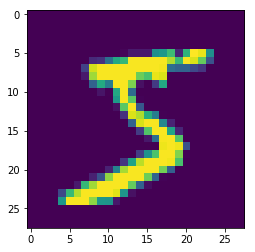

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(train_image[0])

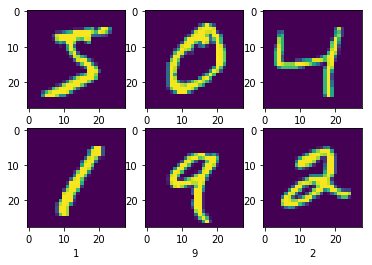

In [9]:
for i,im in enumerate(train_image):
    plt.subplot(231+i)
    plt.imshow(im)
    plt.xlabel(train_label[i])
    if i > 4:
        break

In [21]:
np.array(list_all[0]).shape

(5923, 28, 28)

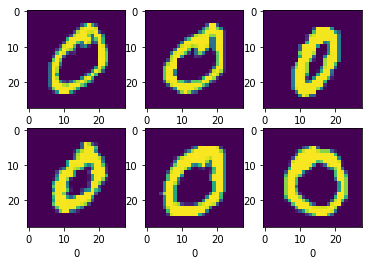

In [22]:
image_0 = np.array(list_all[0])
for i,im in enumerate(image_0):
    plt.subplot(231+i)
    plt.imshow(im)
    plt.xlabel(0)
    if i > 4:
        break

In [2]:
import numpy as np
def load_mnist():
    
    path = '../data_mnist/mnist.npz' #放置mnist.py的目录。注意斜杠
    f = np.load(path)
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)

(train_image,train_label),(test_image,test_label) = load_mnist()

In [19]:
list_all = []
for i in range(0,10):
    list_all.append([])
print(list_all)
for i,im in enumerate(train_image):
    if train_label[i] == 0:
        list_all[0].append(im)
    if train_label[i] == 1:
        list_all[1].append(im)
    if train_label[i] == 2:
        list_all[2].append(im)
    if train_label[i] == 3:
        list_all[3].append(im)
    if train_label[i] == 4:
        list_all[4].append(im)
    if train_label[i] == 5:
        list_all[5].append(im)
    if train_label[i] == 6:
        list_all[6].append(im)
    if train_label[i] == 7:
        list_all[7].append(im)
    if train_label[i] == 8:
        list_all[8].append(im)
    if train_label[i] == 9:
        list_all[9].append(im)

[[], [], [], [], [], [], [], [], [], []]


In [47]:
for i in range(0,10):
    print(str(i)+':'+str(np.array(list_all[i]).shape[0]))

0:5923
1:6742
2:5958
3:6131
4:5842
5:5421
6:5918
7:6265
8:5851
9:5949


In [41]:
from PIL import Image
#im = Image.fromarray(A)
#im.save("out.jpeg")
train_nor = np.array(list_all[0])
#train_abn = np.array(list_all[1:])

for i,im in enumerate(train_nor):
    image = Image.fromarray(im)
    image.save('../data_nor/'+str(i)+'.jpg')



In [44]:
for i in range(1,10):
    train_abn = np.array(list_all[i])
    for j,im in enumerate(train_abn):
        image = Image.fromarray(im)
        image.save('../data_abn/'+str(i)+'_'+str(j)+'.jpg')

In [59]:
import tensorflow as tf

import numpy as np

import tensorflow.examples.tutorials.mnist.input_data as input_data

import math

import scipy

from scipy import ndimage
tf.reset_default_graph()

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
#------------------分割线------------------#

batch_size=1

smooth=0.1

path = '../data_nor'

#------------------分割线------------------#
#use the msra to initialize the parameters
'''
input_: Tensor of input, format NHWC

shape: [filter_height, filter_width, in_channel, out_channel]

k_step: The size of kernel

name: Name of model

'''
def conv2d(input_, shape, k_step, name):

  with tf.variable_scope(name):

    msra_num = 1.0

    fan_in = k_step * k_step * int(input_.get_shape()[-1])

    stddev = msra_num * (math.sqrt(2. / float(fan_in)))

    w = tf.get_variable('w', shape, initializer= tf.truncated_normal_initializer(stddev=stddev))

    b = tf.get_variable('b', [shape[-1]], initializer=tf.constant_initializer(value=0.0))

    conv = tf.nn.conv2d(input_, w, strides=[1,k_step,k_step,1], padding = 'SAME') + b

    return conv

'''
  input_: Tensor of input, format NHWC

  output: [batch, out_height, out_width, out_channel]

  k_step: The size of kernel is k_step*k_step

  d_step: we can define the generated image size, if you define the d_step=2,
          we can get the double size of generated image

'''

def deconv2d(input_, out_shape, k_step, d_step, name):

  with tf.variable_scope(name):

    msra_num = 1.0

    fan_in = k_step * k_step * int(input_.get_shape()[-1])

    stddev = msra_num * (math.sqrt(2. / float(fan_in) * float(d_step) * float(d_step)))

    w = tf.get_variable('w', [k_step, k_step, out_shape[-1], input_.get_shape()[-1]])

    deconv = tf.nn.conv2d_transpose(input_, w, output_shape=out_shape, strides=[1, d_step, d_step, 1])

  return deconv

'''

input_: Tensor of input, format NHWC

shape: [input_channel, out_channel]

'''

def fully_contact(input_, shape, name):

  with tf.variable_scope(name):

    msra_num = 1.0

    fan_in = int(input_.get_shape()[-1])

    stddev = msra_num * (math.sqrt(2./float(fan_in)))

    w = tf.get_variable('w', shape, initializer= tf.truncated_normal_initializer(stddev=stddev))

    b = tf.get_variable('b', shape[-1], initializer= tf.constant_initializer(value=0.0))

    fc = tf.matmul(input_, w) + b

    return fc

'''

define the function of leakrelu

'''

def leakyrelu(x, leak=0.2):

  k1 = (1 + leak)*0.5

  k2 = (1 - leak)*0.5

  return k1 * x + k2 * tf.abs(x)

'''

Restore pixel [-1, 1] to [0, 255]

'''

def rescale_image(image):

  convert_image = (image / 1.5 + 0.5) * 255

  return convert_image

'''

input: The tensor of input, format NHWC

size: recevie the number of images, such as size=8, we can get the 64 images, simultaneously

image_path: the path to store image

colorL: Ture is color image, Flase is gray image

iter: record continous storage images

'''

def save_image(input_, size, image_path, color, iter):

  h, w = input_.shape[1],input_.shape[2]

  convert_input = input_.reshape(batch_size, h, w)

  if color is True:

    image = np.zeros((h * size, w * size, 3))

  else:

    image = np.zeros((h * size, w * size))

  for index, img in enumerate(convert_input):

    i = index % size

    j = math.floor(index / size)

    if color is True:

      image[h*j:h*j+h, i*w:i*w+w,:] = img

    else:

      image[h*j:h*j+h, i*w:i*w+w] = img

  scipy.misc.toimage(rescale_image(image),cmin=0, cmax=255).save(image_path+'/tr_gt_%s.png' % (iter))

#------------------分割线------------------#

def AutoEncoder(input_):

  with tf.variable_scope("Autoencoder", reuse = tf.AUTO_REUSE) as scope0:

      conv1 = conv2d(input_, [5, 5, 1, 32], 2, "conv1")

      conv1 = leakyrelu(conv1)

      conv2 = conv2d(conv1, [5, 5, 32, 64], 2, "conv2")

      conv2 = leakyrelu(conv2)

      deconv1 = deconv2d(conv2, [batch_size, 14, 14, 32], 5, 2, "deconv1")

      deconv1 = leakyrelu(deconv1)

      deconv2 = deconv2d(deconv1, [batch_size, 28, 28, 1], 5, 2, "deconv2")

      output = tf.tanh(deconv2)

      return output

#------------------分割线------------------#
'''

we can define the compute graphy and given the dataset to the graphy,

'''

#with tf.name_scope("input"):

input_image = tf.placeholder(tf.float32, [None, 28, 28, 1], 'input_image')

#------------------分割线------------------#
#with tf.name_scope("network"):

generate_image = AutoEncoder(input_image)

tf.summary.image("output_image", generate_image, 100)

#------------------分割线------------------#
#with tf.name_scope("loss"):

Auto_loss = tf.reduce_mean(tf.reduce_sum(tf.pow(tf.subtract(generate_image, input_image), 2), 3))

tf.summary.scalar("loss", Auto_loss)

#------------------分割线------------------#
train_var = tf.trainable_variables()

#with tf.name_scope("train"):

train_loss = tf.train.AdamOptimizer(0.001, beta1=0.9).minimize(Auto_loss)

init = tf.global_variables_initializer()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)

#------------------分割线------------------#

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
  
  sess.run(init)

  count = 0

  merged = tf.summary.merge_all()

  writer = tf.summary.FileWriter('../logs/logs',sess.graph)

  for i in range(500):

    mnist_image= mnist.train.next_batch(batch_size)

    batch_image = mnist_image[0].reshape(batch_size, 28, 28, 1)

    batch_image = batch_image * 2 - 1

    sess.run(train_loss, feed_dict={input_image: batch_image})

    print(sess.run(Auto_loss, feed_dict={input_image: batch_image}))

    summary = sess.run(merged, feed_dict={input_image: batch_image})

    writer.add_summary(summary, i)

    if i % 100 == 0:

      img = np.array(ndimage.imread('../data_nor/'+str(count)+'.jpg'))

      img = img.reshape(1,28,28,1)

      count += 1

      print(i)

      print(sess.run(Auto_loss, feed_dict={input_image: img}))

      output_image = sess.run(generate_image, feed_dict={input_image: img})

      #result = sess.run(merged, feed_dict={input_image: batch_image})

      summary= sess.run(merged, feed_dict={input_image: img})

      #loss = tf.summary.scalar('loss',result)

      #result = sess.run(merged, feed_dict={input_image: batch_image})

      writer.add_summary(summary, i)

      #save_image(output_image, 8, path, False, i)



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0.48203656
0
8504.352
0.3105142
0.3706599
0.4348839
0.21058236
0.33857983
0.3344985
0.36358923
0.17490211
0.16967456
0.15604034
0.22533152
0.25871927
0.12560245
0.24011536
0.20343465
0.14207152
0.2061283
0.11418654
0.14379932
0.13649394
0.104823396
0.11910039
0.07187242
0.043780968
0.12093135
0.058734544
0.110438384
0.102590755

F:\anaconda\lib\site-packages\ipykernel_launcher.py:267: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.



0.05010507
0.04365714
0.12365134
0.08466238
0.10876739
0.10555915
0.020214163
0.06756144
0.024742987
0.056673665
0.07842264
0.054211047
0.06402442
0.075776085
0.016972449
0.021081792
0.07014543
0.07444645
0.07468428
0.048685454
0.06396171
0.05269511
0.04463736
0.06664535
0.065379106
0.040833857
0.017449435
0.022301173
0.02824956
0.054877017
0.04593411
0.04951178
0.037810925
0.035773356
0.05159427
0.042595025
0.023660908
0.017537188
0.011366011
0.039574705
0.012873472
0.009535121
0.033247452
0.03815034
0.026058065
0.022368591
0.043551773
0.026911328
0.02271537
0.022578007
0.037718188
0.02142629
0.028830364
0.0075563653
0.03824636
0.021187086
0.02663363
0.04039454
0.010622518
0.026163695
0.025272904
0.035694174
0.022932444
0.0147352135
0.031148689
0.0177895
0.030079387
0.0455435
0.03393755
0.016595306
0.038262255
0.014879008
100
9734.788
0.010714153
0.022100193
0.026802292
0.04213303
0.017783012
0.016426267
0.035060264
0.025977291
0.021333577
0.00728305
0.028741185
0.02133765
0.01799489

In [60]:
tf.summary.merge_all(key='summaries')

<tf.Tensor 'Merge_1/MergeSummary:0' shape=() dtype=string>

In [57]:
show_graph(tf.get_default_graph())

In [56]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" οnlοad=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [73]:
import tensorflow as tf

import numpy as np

import tensorflow.examples.tutorials.mnist.input_data as input_data

import math

import scipy

from scipy import ndimage
tf.reset_default_graph()

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
#------------------分割线------------------#

batch_size=1

smooth=0.1

path = '../data_gen'

#------------------分割线------------------#
#use the msra to initialize the parameters
'''
input_: Tensor of input, format NHWC

shape: [filter_height, filter_width, in_channel, out_channel]

k_step: The size of kernel

name: Name of model

'''
def conv2d(input_, shape, k_step, name):

  with tf.variable_scope(name):

    msra_num = 1.0

    fan_in = k_step * k_step * int(input_.get_shape()[-1])

    stddev = msra_num * (math.sqrt(2. / float(fan_in)))

    w = tf.get_variable('w', shape, initializer= tf.truncated_normal_initializer(stddev=stddev))

    b = tf.get_variable('b', [shape[-1]], initializer=tf.constant_initializer(value=0.0))

    conv = tf.nn.conv2d(input_, w, strides=[1,k_step,k_step,1], padding = 'SAME') + b

    return conv

'''
  input_: Tensor of input, format NHWC

  output: [batch, out_height, out_width, out_channel]

  k_step: The size of kernel is k_step*k_step

  d_step: we can define the generated image size, if you define the d_step=2,
          we can get the double size of generated image

'''

def deconv2d(input_, out_shape, k_step, d_step, name):

  with tf.variable_scope(name):

    msra_num = 1.0

    fan_in = k_step * k_step * int(input_.get_shape()[-1])

    stddev = msra_num * (math.sqrt(2. / float(fan_in) * float(d_step) * float(d_step)))

    w = tf.get_variable('w', [k_step, k_step, out_shape[-1], input_.get_shape()[-1]])

    deconv = tf.nn.conv2d_transpose(input_, w, output_shape=out_shape, strides=[1, d_step, d_step, 1])

  return deconv

'''

input_: Tensor of input, format NHWC

shape: [input_channel, out_channel]

'''

def fully_contact(input_, shape, name):

  with tf.variable_scope(name):

    msra_num = 1.0

    fan_in = int(input_.get_shape()[-1])

    stddev = msra_num * (math.sqrt(2./float(fan_in)))

    w = tf.get_variable('w', shape, initializer= tf.truncated_normal_initializer(stddev=stddev))

    b = tf.get_variable('b', shape[-1], initializer= tf.constant_initializer(value=0.0))

    fc = tf.matmul(input_, w) + b

    return fc

'''

define the function of leakrelu

'''

def leakyrelu(x, leak=0.2):

  k1 = (1 + leak)*0.5

  k2 = (1 - leak)*0.5

  return k1 * x + k2 * tf.abs(x)

'''

Restore pixel [-1, 1] to [0, 255]

'''

def rescale_image(image):

  convert_image = (image / 1.5 + 0.5) * 255

  return convert_image

'''

input: The tensor of input, format NHWC

size: recevie the number of images, such as size=8, we can get the 64 images, simultaneously

image_path: the path to store image

colorL: Ture is color image, Flase is gray image

iter: record continous storage images

'''

def save_image(input_, size, image_path, color, iter):

  h, w = input_.shape[1],input_.shape[2]

  convert_input = input_.reshape(batch_size, h, w)

  if color is True:

    image = np.zeros((h * size, w * size, 3))

  else:

    image = np.zeros((h * size, w * size))

  for index, img in enumerate(convert_input):

    i = index % size

    j = math.floor(index / size)

    if color is True:

      image[h*j:h*j+h, i*w:i*w+w,:] = img

    else:

      image[h*j:h*j+h, i*w:i*w+w] = img

  scipy.misc.toimage(rescale_image(image),cmin=0, cmax=255).save(image_path+'/tr_gt_%s.png' % (iter))

#------------------分割线------------------#

def AutoEncoder(input_):

  with tf.variable_scope("Autoencoder", reuse = tf.AUTO_REUSE) as scope0:

      conv1 = conv2d(input_, [5, 5, 1, 32], 2, "conv1")

      conv1 = leakyrelu(conv1)

      conv2 = conv2d(conv1, [5, 5, 32, 64], 2, "conv2")

      conv2 = leakyrelu(conv2)

      deconv1 = deconv2d(conv2, [batch_size, 14, 14, 32], 5, 2, "deconv1")

      deconv1 = leakyrelu(deconv1)

      deconv2 = deconv2d(deconv1, [batch_size, 28, 28, 1], 5, 2, "deconv2")

      output = tf.tanh(deconv2)

      return output

#------------------分割线------------------#
'''

we can define the compute graphy and given the dataset to the graphy,

'''

#with tf.name_scope("input"):

input_image = tf.placeholder(tf.float32, [None, 28, 28, 1], 'input_image')

#------------------分割线------------------#
#with tf.name_scope("network"):

generate_image = AutoEncoder(input_image)

tf.summary.image("output_image", generate_image, 100)

#------------------分割线------------------#
#with tf.name_scope("loss"):

Auto_loss = tf.reduce_mean(tf.reduce_sum(tf.pow(tf.subtract(generate_image, input_image), 2), 3))

tf.summary.scalar("loss", Auto_loss)

#------------------分割线------------------#
train_var = tf.trainable_variables()

#with tf.name_scope("train"):

train_loss = tf.train.AdamOptimizer(0.001, beta1=0.9).minimize(Auto_loss)

init = tf.global_variables_initializer()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)

#------------------分割线------------------#

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
  
  sess.run(init)

  count = 0

  merged = tf.summary.merge_all()

  writer = tf.summary.FileWriter('../logs/logs',sess.graph)

  for i in range(5000):
        
    mnist_image = np.array(ndimage.imread('../data_nor/'+str(i)+'.jpg'))

    batch_image = mnist_image.reshape(batch_size, 28, 28, 1)

    batch_image = batch_image * 2 - 1

    sess.run(train_loss, feed_dict={input_image: batch_image})

    print(sess.run(Auto_loss, feed_dict={input_image: batch_image}))

    summary = sess.run(merged, feed_dict={input_image: batch_image})

    writer.add_summary(summary, i)

    if i % 100 == 0:

      img = np.array(ndimage.imread('../data_abn/1_'+str(count)+'.jpg'))

      img = img.reshape(1,28,28,1)

      count += 1

      print(i)

      print(sess.run(Auto_loss, feed_dict={input_image: img}))

      output_image = sess.run(generate_image, feed_dict={input_image: img})

      #result = sess.run(merged, feed_dict={input_image: batch_image})

      summary= sess.run(merged, feed_dict={input_image: img})

      #loss = tf.summary.scalar('loss',result)

      #result = sess.run(merged, feed_dict={input_image: batch_image})

      writer.add_summary(summary, i)

      save_image(output_image, 8, path, False, i)



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


F:\anaconda\lib\site-packages\ipykernel_launcher.py:251: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
F:\anaconda\lib\site-packages\ipykernel_launcher.py:267: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
F:\anaconda\lib\site-packages\ipykernel_launcher.py:175: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


44927.723
0
4756.79
46161.715
51232.43
46209.355
44859.082
44542.504
45315.0
39950.496
43165.73
45033.395
47362.92
45171.04
46657.887
40052.21
44403.566
44455.52
46533.7
43480.855
43547.297
48126.664
45991.836
42066.418
42175.086
46538.473
46538.18
44189.51
49113.617
44275.97
35436.99
42994.855
46789.062
43376.082
48325.97
45355.85
47412.906
47468.51
44717.254
45574.434
46141.016
47415.453
43913.76
42321.855
42244.652
43025.72
43609.016
42492.395
47030.848
41592.152
45655.496
42342.277
46455.68
45842.695
45118.355
45214.777
49015.92
45609.71
48834.168
46139.105
49941.984
45383.605
45271.664
45626.88
47069.156
46129.895
45448.332
49926.71
45178.656
46459.46
46452.598
45594.92
44167.668
49148.22
40726.547
46374.57
46395.914
51562.03
45556.664
45612.086
44920.664
43309.63
48052.785
47804.938
47067.883
46766.016
46669.812
42145.92
43870.746
44658.99
44618.035
46948.668
45465.3
49902.277
46529.688
44450.914
46193.32
41394.535
45582.42
47016.688
43454.9
44959.598
42195.336
100
4988.41
41651.

44406.496
41613.816
45477.836
47066.65
46754.836
42185.21
47885.973
44966.434
44549.797
50340.652
49655.973
46510.1
45344.832
47516.95
46397.54
46790.63
45647.996
42926.55
49396.312
43466.145
44134.082
43477.26
43231.688
45825.637
46228.812
41640.086
40623.2
42382.266
44975.723
48688.598
44703.656
42157.246
47381.094
46782.164
48670.883
900
6130.512
46927.73
43398.605
43369.746
44137.336
43710.547
44058.67
39640.984
44508.367
39854.96
44282.6
45228.35
43462.01
43304.047
42039.605
42527.895
44245.9
43804.79
44207.285
45472.496
48862.15
48113.87
42880.996
47049.92
43519.133
43026.195
44707.953
43289.684
43253.996
39131.414
47742.53
45083.04
44389.797
44283.8
36727.855
45194.812
44646.52
45489.52
47927.832
43099.297
43113.97
45148.8
47070.867
45459.316
38773.336
42423.363
45896.4
45960.605
46175.35
42076.465
44947.367
44763.33
45203.152
39486.02
42754.43
44473.684
49326.836
51733.33
43355.535
42399.434
48127.586
41825.688
42698.035
41706.164
46811.88
46191.53
40921.332
41857.297
43694.32


42684.88
48904.516
44414.344
51026.21
43709.547
43695.586
48007.72
46574.25
46374.594
45797.035
43876.434
46749.812
46399.48
44364.5
48993.46
44004.312
46657.715
43759.18
49056.63
47207.816
50543.223
46250.582
45581.145
50129.484
51271.586
47901.04
45790.332
49612.348
45588.766
43205.88
42399.367
49725.695
49129.53
47974.65
45402.21
42801.617
45023.914
44777.668
46884.04
48141.566
44086.48
46182.016
47810.703
43404.17
44959.395
46382.32
49817.95
46410.906
49182.76
44570.77
43218.637
43667.434
45450.414
44437.13
44346.99
45473.695
45319.688
46184.53
46877.504
44073.77
44209.332
1800
5787.2417
45966.414
45439.082
47873.2
41546.285
52118.395
48038.95
42798.883
42417.203
41655.6
43935.74
46449.027
44574.695
50153.316
44018.918
45063.902
45389.496
49606.367
41629.152
43605.22
46051.695
41615.46
46910.15
47773.066
43087.348
46607.35
41261.098
46709.87
46903.395
44950.867
47744.254
44273.062
42581.07
43802.383
40508.355
42498.895
41434.21
45482.133
44268.855
45933.133
45544.77
41935.883
42665

46880.68
45036.26
49279.18
43839.086
44651.633
44636.43
46630.098
42211.0
44192.03
44488.062
44129.047
42410.348
50338.086
44930.82
46453.01
42248.223
45335.746
40195.914
44081.52
44037.598
46555.53
46606.723
46367.473
45541.918
42940.082
43156.99
46277.6
51470.645
44374.65
44268.902
46026.215
41591.938
48503.285
49405.02
45523.496
41414.887
43895.902
45474.62
42111.945
43186.414
46267.26
45799.79
48540.54
46001.5
41332.96
44127.098
47604.48
42275.414
44285.535
43462.438
41733.03
44016.367
44865.496
48142.93
47916.566
46544.96
46669.004
46166.598
43480.547
43446.203
46602.2
49365.42
43498.3
45978.28
45456.92
47193.223
45683.188
42863.8
47441.703
45991.863
45314.27
42938.297
42927.562
44298.664
43079.914
41255.42
43071.45
44551.9
43151.297
44350.383
50604.02
44229.934
45515.438
45459.965
46649.43
39285.48
45923.496
51567.754
43016.906
44501.613
45801.98
46173.25
45950.26
47739.805
49918.605
43384.484
43056.465
45124.688
47329.066
45559.047
2700
5080.405
44495.906
48049.67
41500.367
4668

46995.797
40844.547
45772.55
46496.418
45006.734
45970.47
45334.28
44666.387
47063.137
43573.18
43723.645
47003.6
46734.844
47120.117
47356.348
44555.785
45100.887
43145.086
44012.62
45109.547
48010.473
42064.254
45345.6
44158.215
45302.82
46254.684
43100.348
43129.246
45633.68
45458.535
44602.332
44947.51
46254.418
44723.348
46123.562
42055.465
3500
4249.8975
41807.164
45791.887
43223.688
45485.17
42881.03
44398.223
43358.52
47010.055
46359.97
43458.816
44584.918
49208.402
45858.45
45626.516
44513.164
47160.8
45113.895
45704.867
45058.45
43463.57
45544.887
44065.49
42681.13
44390.902
42615.47
42282.586
46420.812
47107.715
45502.383
44929.945
42896.47
43430.71
41162.168
43266.395
44659.047
44444.496
46393.066
46961.887
44682.082
44640.348
43994.027
44681.465
45422.246
49797.367
45497.484
42178.645
49171.395
44713.29
43485.79
40399.344
45657.344
47145.22
50138.92
48944.32
47071.082
49401.29
44901.867
44333.766
43363.27
45009.688
44240.406
45072.688
44101.5
44680.53
45885.01
44310.094
44

44380.203
50968.973
49255.52
49073.48
47612.812
44900.74
44738.137
46390.336
46029.21
45401.254
45199.4
46602.883
46414.137
44046.7
44607.367
44432.785
39541.18
48561.535
42915.906
46525.836
44835.195
46765.93
46384.934
48016.836
47665.336
42831.82
40638.855
42541.133
48901.598
40987.906
44558.54
45743.65
43591.887
46115.3
40662.137
43220.863
48354.965
45121.203
45071.246
42446.76
45779.07
47151.0
45143.383
48105.055
45282.047
47441.582
43916.844
44769.137
45357.832
43426.266
42373.598
45350.305
46037.938
47256.598
47861.805
47469.99
48861.562
43480.465
40380.066
45339.13
46442.605
39640.535
46545.547
45192.95
45684.785
43228.867
45750.617
45819.254
44688.5
43832.88
47581.547
41388.87
46083.7
45750.895
46809.598
46415.473
45945.113
44042.465
52564.004
44672.418
44184.57
4400
5435.4277
43984.312
50736.594
45009.95
44451.855
46477.152
44641.254
44762.87
47143.035
44257.85
42118.6
50085.83
45783.938
46589.797
39092.96
45793.95
40453.113
48057.266
48005.28
47170.46
44395.684
44975.094
4499

In [61]:
mnist_image= mnist.train.next_batch(batch_size)

In [69]:
mnist_image[1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [89]:
import numpy as np
import csv
from sklearn.model_selection import train_test_split
def load_data(m = 290,n = 342,file_name_list =['正常工况_30Hz.csv','地脚螺栓松动_1个_30Hz.csv','出口小风机对吹_30Hz.csv','进风口堵塞75%_30Hz.csv','进口小风机对吹_30Hz.csv','转子不平衡_30Hz.csv','敲击壳体_30Hz.csv']):    
    file_path = '../data/'
    x = []
    y = []
    for k in range(len(file_name_list)):
        file_name = file_path + file_name_list[k]
        f = open(file_name, 'r',encoding = 'gbk')
        csvreader = csv.reader(f)
        data1 = np.array(list(csvreader))
        data1 = data1[1:,1:]
        for i in range(m):
            y.append(k)
            temp_data = []
            for j in range(10):
                temp_data.append(data1[n * i: (i * n + n ) ,j])
            x.append(temp_data)
    x = np.array(x)
    x = x.reshape(x.shape[0],10,x.shape[2],1)
    #x_train,x_val,y_train,y_val = train_test_split(x,y,test_size = 0.3,random_state = 2019)
    x_train = x[0:290,:,:,:]
    x_val = x[290:,:,:,:]
    return (x_train,x_val)


In [79]:
(x_train,y_train),(x_val,y_val) = load_data()

In [82]:
x_train.shape

(1421, 10, 342, 1)

In [88]:
y_train[290]

5

In [90]:
if __name__ == '__main__':
    num = 7
    channels = 10
    dropout = 0.2
    nb_epochs = 700
    batch_size = 50
    data_row = 342
    data_column = 1
    trainpath = r'./data'

    (x_train,x_val) = load_data()
    #y_train = to_categorical(y_train)
    #y_val   = to_categorical(y_val)


    #tf.keras.backend.set_image_data_format('channels_last')

    temp_x_train = []
    for i in range(len(x_train)):
        new_x_train_row=np.moveaxis(x_train[i],0,2)
        temp_x_train.append(new_x_train_row)

    temp_x_val = []
    for i in range(len(x_val)):
        new_x_val_row=np.moveaxis(x_val[i],0,2)
        temp_x_val.append(new_x_val_row)


    x_train = np.array(temp_x_train)
    x_val   = np.array(temp_x_val)

    input_shape = (data_row, data_column,channels)

    x_train = x_train.astype('float32')
    x_val   = x_val.astype('float32')

    print('train dataset size:',x_train.shape[0])
    print('validation dataset size:',x_val.shape[0])

    #num_classes = y_train.shape[1]

train dataset size: 290
validation dataset size: 1740


In [86]:
x_train.shape

(1421, 342, 1, 10)

In [ ]:
import tensorflow as tf

import numpy as np

import tensorflow.examples.tutorials.mnist.input_data as input_data

import math

import scipy

from scipy import ndimage
tf.reset_default_graph()

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
#------------------分割线------------------#

batch_size=1

smooth=0.1

path = '../data_gen'

#------------------分割线------------------#
#use the msra to initialize the parameters
'''
input_: Tensor of input, format NHWC

shape: [filter_height, filter_width, in_channel, out_channel]

k_step: The size of kernel

name: Name of model

'''
def conv2d(input_, shape, k_step, name):

  with tf.variable_scope(name):

    msra_num = 1.0

    fan_in = k_step * k_step * int(input_.get_shape()[-1])

    stddev = msra_num * (math.sqrt(2. / float(fan_in)))

    w = tf.get_variable('w', shape, initializer= tf.truncated_normal_initializer(stddev=stddev))

    b = tf.get_variable('b', [shape[-1]], initializer=tf.constant_initializer(value=0.0))

    conv = tf.nn.conv2d(input_, w, strides=[1,k_step,k_step,1], padding = 'SAME') + b

    return conv

'''
  input_: Tensor of input, format NHWC

  output: [batch, out_height, out_width, out_channel]

  k_step: The size of kernel is k_step*k_step

  d_step: we can define the generated image size, if you define the d_step=2,
          we can get the double size of generated image

'''

def deconv2d(input_, out_shape, k_step, d_step, name):

  with tf.variable_scope(name):

    msra_num = 1.0

    fan_in = k_step * k_step * int(input_.get_shape()[-1])

    stddev = msra_num * (math.sqrt(2. / float(fan_in) * float(d_step) * float(d_step)))

    w = tf.get_variable('w', [k_step, k_step, out_shape[-1], input_.get_shape()[-1]])

    deconv = tf.nn.conv2d_transpose(input_, w, output_shape=out_shape, strides=[1, d_step, d_step, 1])

  return deconv

'''

input_: Tensor of input, format NHWC

shape: [input_channel, out_channel]

'''

def fully_contact(input_, shape, name):

  with tf.variable_scope(name):

    msra_num = 1.0

    fan_in = int(input_.get_shape()[-1])

    stddev = msra_num * (math.sqrt(2./float(fan_in)))

    w = tf.get_variable('w', shape, initializer= tf.truncated_normal_initializer(stddev=stddev))

    b = tf.get_variable('b', shape[-1], initializer= tf.constant_initializer(value=0.0))

    fc = tf.matmul(input_, w) + b

    return fc

'''

define the function of leakrelu

'''

def leakyrelu(x, leak=0.2):

  k1 = (1 + leak)*0.5

  k2 = (1 - leak)*0.5

  return k1 * x + k2 * tf.abs(x)

'''

Restore pixel [-1, 1] to [0, 255]

'''

def rescale_image(image):

  convert_image = (image / 1.5 + 0.5) * 255

  return convert_image

'''

input: The tensor of input, format NHWC

size: recevie the number of images, such as size=8, we can get the 64 images, simultaneously

image_path: the path to store image

colorL: Ture is color image, Flase is gray image

iter: record continous storage images

'''

def save_image(input_, size, image_path, color, iter):

  h, w = input_.shape[1],input_.shape[2]

  convert_input = input_.reshape(batch_size, h, w)

  if color is True:

    image = np.zeros((h * size, w * size, 3))

  else:

    image = np.zeros((h * size, w * size))

  for index, img in enumerate(convert_input):

    i = index % size

    j = math.floor(index / size)

    if color is True:

      image[h*j:h*j+h, i*w:i*w+w,:] = img

    else:

      image[h*j:h*j+h, i*w:i*w+w] = img

  scipy.misc.toimage(rescale_image(image),cmin=0, cmax=255).save(image_path+'/tr_gt_%s.png' % (iter))

#------------------分割线------------------#

def AutoEncoder(input_):

  with tf.variable_scope("Autoencoder", reuse = tf.AUTO_REUSE) as scope0:

      conv1 = conv2d(input_, [5, 5, 1, 32], 2, "conv1")

      conv1 = leakyrelu(conv1)

      conv2 = conv2d(conv1, [5, 5, 32, 64], 2, "conv2")

      conv2 = leakyrelu(conv2)

      deconv1 = deconv2d(conv2, [batch_size, 14, 14, 32], 5, 2, "deconv1")

      deconv1 = leakyrelu(deconv1)

      deconv2 = deconv2d(deconv1, [batch_size, 28, 28, 1], 5, 2, "deconv2")

      output = tf.tanh(deconv2)

      return output

#------------------分割线------------------#
'''

we can define the compute graphy and given the dataset to the graphy,

'''

#with tf.name_scope("input"):

input_image = tf.placeholder(tf.float32, [None, 28, 28, 1], 'input_image')

#------------------分割线------------------#
#with tf.name_scope("network"):

generate_image = AutoEncoder(input_image)

tf.summary.image("output_image", generate_image, 100)

#------------------分割线------------------#
#with tf.name_scope("loss"):

Auto_loss = tf.reduce_mean(tf.reduce_sum(tf.pow(tf.subtract(generate_image, input_image), 2), 3))

tf.summary.scalar("loss", Auto_loss)

#------------------分割线------------------#
train_var = tf.trainable_variables()

#with tf.name_scope("train"):

train_loss = tf.train.AdamOptimizer(0.001, beta1=0.9).minimize(Auto_loss)

init = tf.global_variables_initializer()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)

#------------------分割线------------------#

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
  
  sess.run(init)

  count = 0

  merged = tf.summary.merge_all()

  writer = tf.summary.FileWriter('../logs/logs',sess.graph)

  for i in range(5000):
        
    mnist_image = np.array(ndimage.imread('../data_nor/'+str(i)+'.jpg'))

    batch_image = mnist_image.reshape(batch_size, 28, 28, 1)

    batch_image = batch_image * 2 - 1

    sess.run(train_loss, feed_dict={input_image: batch_image})

    print(sess.run(Auto_loss, feed_dict={input_image: batch_image}))

    summary = sess.run(merged, feed_dict={input_image: batch_image})

    writer.add_summary(summary, i)

    if i % 100 == 0:

      img = np.array(ndimage.imread('../data_abn/1_'+str(count)+'.jpg'))

      img = img.reshape(1,28,28,1)

      count += 1

      print(i)

      print(sess.run(Auto_loss, feed_dict={input_image: img}))

      output_image = sess.run(generate_image, feed_dict={input_image: img})

      #result = sess.run(merged, feed_dict={input_image: batch_image})

      summary= sess.run(merged, feed_dict={input_image: img})

      #loss = tf.summary.scalar('loss',result)

      #result = sess.run(merged, feed_dict={input_image: batch_image})

      writer.add_summary(summary, i)

      save_image(output_image, 8, path, False, i)

